In [1]:
# 导入模块
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import leastsq
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [2]:
# 读取数据
camEdge = pd.read_excel("../附件/附件1-凸轮边缘曲线.xlsx") # 读取凸轮边缘曲线数据
valve = pd.read_excel("../附件/附件2-针阀运动曲线.xlsx")  # 读取针阀运动曲线数据
elastic = pd.read_excel("../附件/附件3-弹性模量与压力.xlsx")  # 读取弹性模量与压力数据

Text(0.5, 1.0, '凸轮边缘曲线')

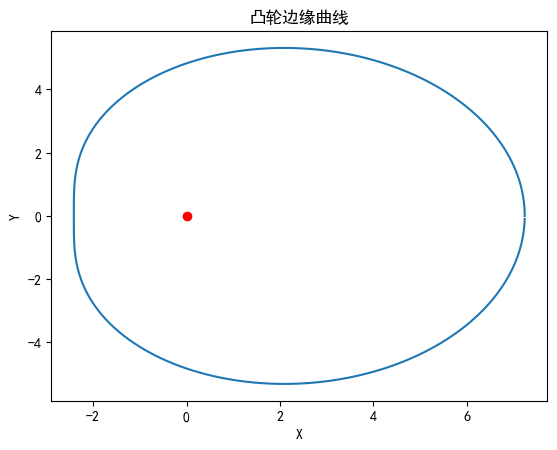

In [3]:
# 绘制凸轮边缘曲线
plt.plot(camEdge['X'],camEdge['Y'], label='凸轮边缘曲线') # 绘制凸轮边缘曲线
plt.scatter(0,0, color='red', label='中心点') # 绘制中心点
plt.xlabel('X') # 设置X轴标签
plt.ylabel('Y') # 设置Y轴标签
plt.title('凸轮边缘曲线') # 设置标题


Text(0.5, 1.0, '针阀运动曲线')

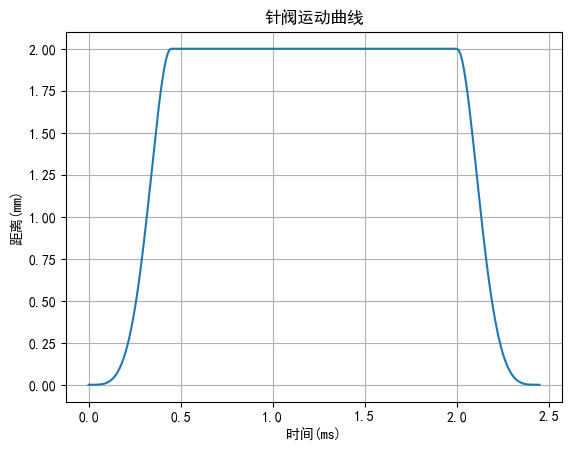

In [4]:
# 绘制针阀运动曲线
plt.plot(valve['时间(ms)'],valve['距离(mm)'], label='针阀运动曲线') # 绘制针阀运动曲线
plt.grid() # 显示网格
plt.xlabel('时间(ms)') # 设置X轴标签
plt.ylabel('距离(mm)') # 设置Y轴标签
plt.title('针阀运动曲线') # 设置标题

拟合参数: [ 1.00037752e-04 -1.08248140e-03  5.47444434e+00  1.53186841e+03]
        3            2
0.0001 x - 0.001082 x + 5.474 x + 1532
R^2: 0.9999730942437174


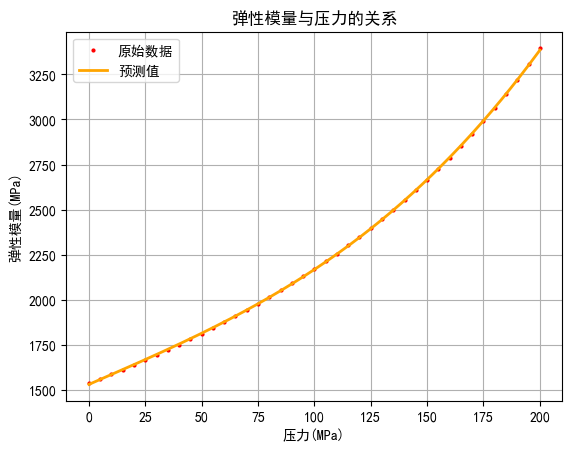

In [5]:
# 用最小二乘法拟合elastic参数

p0 = [100, 20,10,10] # 初始参数
Xi= elastic['压力(MPa)']
Yi= elastic['弹性模量(MPa)']


# 最小二乘法拟合
E_fit = np.polyfit(Xi, Yi, 3) # 拟合3次多项式
print("拟合参数:",E_fit)
E_fit_func = np.poly1d(E_fit)
print(E_fit_func)

# 计算R2
SSR = sum((Yi - E_fit_func(Xi))**2)
SST = sum((Yi - np.mean(Yi))**2)
R2 = 1 - SSR/SST
print("R^2:",R2)

# 绘图
# plt.figure(figsize=(8,6))
plt.plot(Xi[::10],Yi[::10],color="red", markersize=2,marker="o",label="原始数据",linewidth=0)
x = Xi
y = E_fit_func(x)
plt.plot(x,y,color="orange",label="预测值",linewidth=2)

plt.xlabel("压力(MPa)")
plt.ylabel("弹性模量(MPa)")
plt.title("弹性模量与压力的关系")
plt.grid()
plt.legend()
plt.show()  

            2
-6.558e-07 x + 0.0005226 x + 0.8043
R^2= 0.9999998838294892
相对误差的最大值： 1.4584334211894977e-05


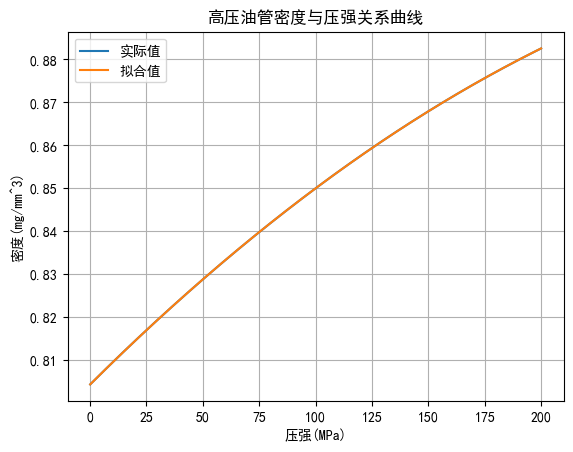

In [6]:
# 高压油管密度与压强关系曲线
from scipy.integrate import odeint

def E(P):
    return E_fit_func(P)

def drho_dP(rho, P):
    return rho / E(P)

# 初始条件
P_0 = 100  # initial pressure
rho_0 = 0.85  # initial density

# P 的范围
P_values_forward = np.arange(P_0, 200, 0.1)

# Solve the ODE forward
rho_values_forward = odeint(drho_dP, rho_0, P_values_forward)

# Range of P values for backward integration (from 100 to 0)
P_values_backward = np.arange(P_0, 0, -0.1)

# Solve the ODE backward
rho_values_backward = odeint(drho_dP, rho_0, P_values_backward)

# Combine the results
P_values_combined = np.concatenate((P_values_backward[::-1], P_values_forward[1:]))
rho_values_combined = np.concatenate((rho_values_backward[::-1].flatten(), rho_values_forward[1:].flatten()))

# 拟合曲线
rho_fit = np.polyfit(P_values_combined, rho_values_combined, 2)
rho_fit_func = np.poly1d(rho_fit)
print(rho_fit_func)

# 计算R^2
y_mean = np.mean(rho_values_combined)
SS_tot = np.sum((rho_values_combined - y_mean)**2)
SS_res = np.sum((rho_values_combined - rho_fit_func(P_values_combined))**2)
R_squared = 1 - SS_res / SS_tot
print("R^2=",R_squared)
# 计算相对误差
rho_values_relative_error = np.abs((rho_values_combined - rho_fit_func(P_values_combined)) / rho_values_combined)
print("相对误差的最大值：",np.max(rho_values_relative_error))

# 绘图
plt.plot(P_values_combined, rho_values_combined, label='实际值')
plt.plot(P_values_combined, rho_fit_func(P_values_combined), label='拟合值')
plt.xlabel('压强(MPa)')
plt.ylabel('密度(mg/mm^3)')
plt.title('高压油管密度与压强关系曲线')
plt.legend()
plt.grid(True)
plt.show()


           3             2
1.433e+05 x - 3.515e+05 x + 2.895e+05 x - 7.999e+04
(100, 1) (100,)
SS_tot = 643556.6922645898
SS_res = 69.06896674767415
R^2 = 0.9998926761735557


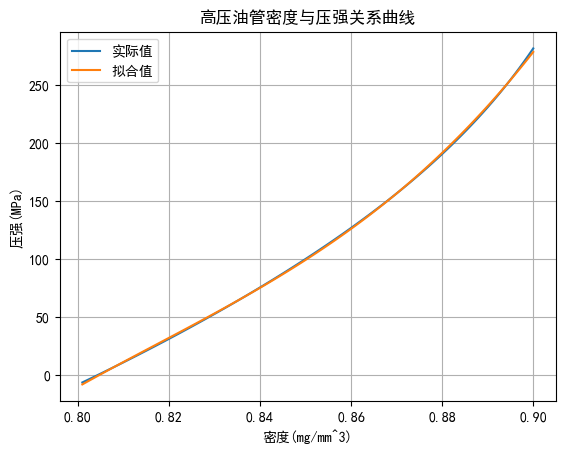

In [20]:
# 高压油管密度与压强关系曲线
from scipy.integrate import odeint

def E(P):
    return E_fit_func(P)

def dP_drho(P,rho):
    return  E(P) / rho 

# 初始条件
P_0 = 100  # initial pressure
rho_0 = 0.85  # initial density

# rho 的范围
rho_values_forward = np.arange(rho_0, 0.9, 0.001)

# Solve the ODE forward
P_values_forward = odeint(dP_drho, P_0, rho_values_forward)

# Range of P values for backward integration (from 100 to 0)
rho_values_backward = np.arange(rho_0, 0.8, -0.001)

# Solve the ODE backward
P_values_backward = odeint(dP_drho, P_0, rho_values_backward)

# Combine the results
P_values_combined = np.concatenate((P_values_backward[::-1], P_values_forward[1:]))
rho_values_combined = np.concatenate((rho_values_backward[::-1].flatten(), rho_values_forward[1:].flatten()))

# 拟合曲线
PRho_fit = np.polyfit(rho_values_combined, P_values_combined, 3)
PRho_fit_func = np.poly1d(PRho_fit.flatten())
print(PRho_fit_func)

# 计算R^2
y_mean = np.mean(P_values_combined)
SS_tot = np.sum((P_values_combined.flatten() - y_mean)**2)
SS_res = np.sum((P_values_combined.flatten() - PRho_fit_func(rho_values_combined))**2)
# print(P_values_combined.shape,PRho_fit_func(rho_values_combined).shape)
print('SS_tot =', SS_tot)
print('SS_res =', SS_res)
R_squared = 1 - SS_res / SS_tot
print('R^2 =', R_squared)


# 绘图
plt.plot(rho_values_combined, P_values_combined, label='实际值')
plt.plot(rho_values_combined, PRho_fit_func(rho_values_combined), label='拟合值')
plt.ylabel('压强(MPa)')
plt.xlabel('密度(mg/mm^3)')
plt.title('高压油管密度与压强关系曲线')
plt.legend()
plt.grid(True)
plt.show()
